# Model Setup

Make final adjustments to the dataframe and train/test models. Cell below import relevant packages and rename columns in the table to make the distinction between data in the tables.

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textdistance
import time
import itertools, json
from pprint import pprint
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn import metrics, svm
from sklearn.ensemble import RandomForestClassifier
import separateGUsers as sgu

usersG = pd.read_csv("usersGoogle.csv", sep=",", index_col="id", quotechar="\"", encoding="utf-8", engine="c")
usersT = pd.read_csv("usersTrueTwitter.csv", sep=",", index_col="id_str", encoding="utf-8", engine='python')

usersG = usersG.rename(index=str, columns={"id": "G_id", "fullname": "G_name", "displayName": "G_username", "primary_location": "G_location", 
              "description": "G_description", "circledByCount": "G_friends", "gender": "G_gender", "gender_enc": "G_gender_enc"})
usersT = usersT.rename(index=str, columns={"id_str": "T_id", "name": "T_name", "screen_name": "T_username", "location": "T_location", 
             "description": "T_description", "friends_count": "T_friends", "gender": "T_gender", "gender_enc":"T_gender_enc"})

In [7]:
usersG

,G_name,G_username,G_location,G_description,G_friends,G_gender,G_gender_enc
id,,,,,,,
104288964437721273491,Johnny Oliveira,Johnny Oliveira,"São Paulo, Brasil.","Think, Believe and Make it Happen. Technology ...",0,male,1
100301662419920433743,Justin Esparza,Justin Esparza,HB,NaN,0,male,1
115233306327496577248,"Bert Gives, Jr","Bert Gives, Jr",Valley Stream,License Notary & Certified Loan Signing Agent ...,224,male,1
114450247448428643447,Michael Olivero,Michael Olivero,NaN,Software,None,male,1
106057007019277820892,Elidier Moya,Elidier Moya,NaN,NaN,73,male,1
115538752986453113378,Ashutosh Jha,Ashutosh Jha,"Toronto, Canada","Army of One, One of Army Creative & Social Ent...",222,male,1
108359110716028319267,ignacio perez alvarez,ignacio perez alvarez,NaN,cocinero,0,male,1
117585428399967312212,Bárbara Botello,Bárbara Botello,NaN,NaN,79,female,2
112929377664095396761,Emilia Miller,Emilia Miller,NaN,NaN,1,female,2


Read Google+ ID and Twitter IDs, store them as a dataframe to perform the merging operation

In [8]:
idPairs = sgu.read_GID_TID_pairs()
fulltable = pd.DataFrame(data={"G_id":list(idPairs.keys()), "T_id":list(idPairs.values())})
fulltable.head()

,G_id,T_id
0,104288964437721273491,51526927
1,100301662419920433743,235020718
2,115233306327496577248,22450750
3,114450247448428643447,8011132
4,106057007019277820892,96217215


In [9]:
fulltable = fulltable.merge(usersG, left_on="G_id", right_on="id")
fulltable = fulltable.merge(usersT, left_on="T_id", right_on="id_str")
fulltable.set_index(['G_id', 'T_id'])
fulltable

,G_id,T_id,G_name,G_username,G_location,G_description,G_friends,G_gender,G_gender_enc,T_name,T_username,T_location,T_description,T_friends,T_gender,T_gender_enc
0,100301662419920433743,235020718,Justin Esparza,Justin Esparza,HB,NaN,0,male,1,Justin Esparza,JooseBoks,h.b. so.cali,You can tell from my speech that I come from t...,132,male,1
1,115233306327496577248,22450750,"Bert Gives, Jr","Bert Gives, Jr",Valley Stream,License Notary & Certified Loan Signing Agent ...,224,male,1,"Bert J. Gives, Jr.",bkbert23,"Bklyn, NYC","Notary Public, NSA.\n\nForeclosure Assitance,\...",2515,unknown,0
2,114450247448428643447,8011132,Michael Olivero,Michael Olivero,NaN,Software,None,male,1,mike95,mike95,NaN,NaN,56,male,1
3,106057007019277820892,96217215,Elidier Moya,Elidier Moya,NaN,NaN,73,male,1,Elidier Moya,elidier_,Costa Rica,"Ingeniero en sistemas de información, con una ...",279,unknown,0
4,115538752986453113378,98688710,Ashutosh Jha,Ashutosh Jha,"Toronto, Canada","Army of One, One of Army Creative & Social Ent...",222,male,1,Ashutosh Jha,ajha1,"Toronto, Canada & Delhi, India",Student of #Entrepreneurship & #Life; Projects...,208,male,1
5,108359110716028319267,139496318,ignacio perez alvarez,ignacio perez alvarez,NaN,cocinero,0,male,1,Ignacio Perez,rizos46,Madrid,1990,609,male,1
6,117585428399967312212,227128132,Bárbara Botello,Bárbara Botello,NaN,NaN,79,female,2,Bárbara Botello,Barbara_Botello,NaN,"Diputada federal del PRI por Guanajuato, en la...",1666,unknown,0
7,112929377664095396761,64238125,Emilia Miller,Emilia Miller,NaN,NaN,1,female,2,Emilia Miller,EmiliaMaria76,"Douglassville, PA",~Oncology Nurse~ Pitbull mom -Alvernia '17-,280,female,2
8,100502806126131626792,17189517,per suede,per suede,"brooklyn, new york",modern. organic. made for you Making pretty th...,29,female,2,persuede,persuede,Brooklyn,pretty is good,517,unknown,0
9,113976667959203378689,15921118,Ren Newman,Ren Newman,NaN,Being a Christian is a 24/7 job. 24/7 Christian,None,male,1,Ren Newman,ren_new,Philippines,"Likes Architecture, Books, Computers, Design, ...",14,unknown,0


In [10]:
print(fulltable.duplicated().value_counts())
fulltable = fulltable.drop_duplicates()
fulltable.shape

False    6904
True      551
dtype: int64


(6904, 16)

Add consistency to gender entries now only male, female and unknown

In [11]:
def uniformGender(gender):
    if gender == "None" or gender == "other":
        return "unknown"
    return gender

fulltable['G_gender'] = fulltable.G_gender.apply(lambda x: uniformGender(x))

C:\Users\Dante\Anaconda3\envs\mscproj\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [12]:
print(fulltable.T_gender.value_counts())
print(fulltable.G_gender.value_counts())

unknown    3416
male       2537
female      951
Name: T_gender, dtype: int64
male       4544
female     1572
unknown     788
Name: G_gender, dtype: int64


In [13]:
fulltable

,G_id,T_id,G_name,G_username,G_location,G_description,G_friends,G_gender,G_gender_enc,T_name,T_username,T_location,T_description,T_friends,T_gender,T_gender_enc
0,100301662419920433743,235020718,Justin Esparza,Justin Esparza,HB,NaN,0,male,1,Justin Esparza,JooseBoks,h.b. so.cali,You can tell from my speech that I come from t...,132,male,1
1,115233306327496577248,22450750,"Bert Gives, Jr","Bert Gives, Jr",Valley Stream,License Notary & Certified Loan Signing Agent ...,224,male,1,"Bert J. Gives, Jr.",bkbert23,"Bklyn, NYC","Notary Public, NSA.\n\nForeclosure Assitance,\...",2515,unknown,0
2,114450247448428643447,8011132,Michael Olivero,Michael Olivero,NaN,Software,None,male,1,mike95,mike95,NaN,NaN,56,male,1
3,106057007019277820892,96217215,Elidier Moya,Elidier Moya,NaN,NaN,73,male,1,Elidier Moya,elidier_,Costa Rica,"Ingeniero en sistemas de información, con una ...",279,unknown,0
4,115538752986453113378,98688710,Ashutosh Jha,Ashutosh Jha,"Toronto, Canada","Army of One, One of Army Creative & Social Ent...",222,male,1,Ashutosh Jha,ajha1,"Toronto, Canada & Delhi, India",Student of #Entrepreneurship & #Life; Projects...,208,male,1
5,108359110716028319267,139496318,ignacio perez alvarez,ignacio perez alvarez,NaN,cocinero,0,male,1,Ignacio Perez,rizos46,Madrid,1990,609,male,1
6,117585428399967312212,227128132,Bárbara Botello,Bárbara Botello,NaN,NaN,79,female,2,Bárbara Botello,Barbara_Botello,NaN,"Diputada federal del PRI por Guanajuato, en la...",1666,unknown,0
7,112929377664095396761,64238125,Emilia Miller,Emilia Miller,NaN,NaN,1,female,2,Emilia Miller,EmiliaMaria76,"Douglassville, PA",~Oncology Nurse~ Pitbull mom -Alvernia '17-,280,female,2
8,100502806126131626792,17189517,per suede,per suede,"brooklyn, new york",modern. organic. made for you Making pretty th...,29,female,2,persuede,persuede,Brooklyn,pretty is good,517,unknown,0
9,113976667959203378689,15921118,Ren Newman,Ren Newman,NaN,Being a Christian is a 24/7 job. 24/7 Christian,None,male,1,Ren Newman,ren_new,Philippines,"Likes Architecture, Books, Computers, Design, ...",14,unknown,0


In [14]:
g_gender = fulltable.G_gender
t_gender = fulltable.T_gender

total_male = 0
total_female = 0
total_unknown = 0
male_guess = 0
female_guess = 0
unknown_guess = 0

for g,t in zip(g_gender, t_gender):
    if (t == "male"):
        total_male += 1
        if (t == g):
            male_guess += 1
    elif (t == "female"):
        total_female += 1
        if (t == g):
            female_guess += 1
    else:
        total_unknown += 1
        if (t == g):
            unknown_guess += 1
    
print(f'Total guesses for all = {total_male + total_female + total_unknown}\nMales Correctly guessed {male_guess} of {total_male}, {round((male_guess/total_male)*100,1)}%\nFemales Correctly guessed {female_guess} of {total_female}, {round((female_guess/total_female)*100,1)}%\nUnknowns Correctly guessed {unknown_guess} of {total_unknown}, {round((unknown_guess/total_unknown)*100,1)}%')

Total guesses for all = 6904
Males Correctly guessed 2311 of 2537, 91.1%
Females Correctly guessed 805 of 951, 84.6%
Unknowns Correctly guessed 535 of 3416, 15.7%


In [15]:
print("Female Rates")
print(f'805 of females correctly guessed of 1572 total, {round(80500/1572, 1)}%')
print("Male Rates")
print(f'2311 of males correctly guessed of 4544 total, {round(231100/4544, 1)}%')


Female Rates
805 of females correctly guessed of 1572 total, 51.2%
Male Rates
2311 of males correctly guessed of 4544 total, 50.9%


In [16]:
fulltable['same_person'] = 1
fulltable

C:\Users\Dante\Anaconda3\envs\mscproj\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,G_id,T_id,G_name,G_username,G_location,G_description,G_friends,G_gender,G_gender_enc,T_name,T_username,T_location,T_description,T_friends,T_gender,T_gender_enc,same_person
0,100301662419920433743,235020718,Justin Esparza,Justin Esparza,HB,NaN,0,male,1,Justin Esparza,JooseBoks,h.b. so.cali,You can tell from my speech that I come from t...,132,male,1,1
1,115233306327496577248,22450750,"Bert Gives, Jr","Bert Gives, Jr",Valley Stream,License Notary & Certified Loan Signing Agent ...,224,male,1,"Bert J. Gives, Jr.",bkbert23,"Bklyn, NYC","Notary Public, NSA.\n\nForeclosure Assitance,\...",2515,unknown,0,1
2,114450247448428643447,8011132,Michael Olivero,Michael Olivero,NaN,Software,None,male,1,mike95,mike95,NaN,NaN,56,male,1,1
3,106057007019277820892,96217215,Elidier Moya,Elidier Moya,NaN,NaN,73,male,1,Elidier Moya,elidier_,Costa Rica,"Ingeniero en sistemas de información, con una ...",279,unknown,0,1
4,115538752986453113378,98688710,Ashutosh Jha,Ashutosh Jha,"Toronto, Canada","Army of One, One of Army Creative & Social Ent...",222,male,1,Ashutosh Jha,ajha1,"Toronto, Canada & Delhi, India",Student of #Entrepreneurship & #Life; Projects...,208,male,1,1
5,108359110716028319267,139496318,ignacio perez alvarez,ignacio perez alvarez,NaN,cocinero,0,male,1,Ignacio Perez,rizos46,Madrid,1990,609,male,1,1
6,117585428399967312212,227128132,Bárbara Botello,Bárbara Botello,NaN,NaN,79,female,2,Bárbara Botello,Barbara_Botello,NaN,"Diputada federal del PRI por Guanajuato, en la...",1666,unknown,0,1
7,112929377664095396761,64238125,Emilia Miller,Emilia Miller,NaN,NaN,1,female,2,Emilia Miller,EmiliaMaria76,"Douglassville, PA",~Oncology Nurse~ Pitbull mom -Alvernia '17-,280,female,2,1
8,100502806126131626792,17189517,per suede,per suede,"brooklyn, new york",modern. organic. made for you Making pretty th...,29,female,2,persuede,persuede,Brooklyn,pretty is good,517,unknown,0,1
9,113976667959203378689,15921118,Ren Newman,Ren Newman,NaN,Being a Christian is a 24/7 job. 24/7 Christian,None,male,1,Ren Newman,ren_new,Philippines,"Likes Architecture, Books, Computers, Design, ...",14,unknown,0,1


__Let's create some Negative Instances__

In [17]:
userDict = sgu.read_GID_TID_pairs()
G_id = list(userDict.keys())
T_id = list(userDict.values())

np.random.shuffle(T_id)
negUsers = {}
duplicates = 0

for g,t in zip(G_id, T_id):
    if (userDict[g] == t):
        duplicates += 1
    else:
        negUsers[g] = t

print(f'Number pairs still present in the original dictionary {duplicates}')

Number pairs still present in the original dictionary 0


In [18]:
negTable = pd.DataFrame(data={"G_id":list(negUsers.keys()), "T_id":list(negUsers.values())})
negTable = negTable.merge(usersG, left_on="G_id", right_on="id")
negTable = negTable.merge(usersT, left_on="T_id", right_on="id_str")
negTable.set_index(['G_id', 'T_id'])
negTable['same_person'] = 0
negTable

,G_id,T_id,G_name,G_username,G_location,G_description,G_friends,G_gender,G_gender_enc,T_name,T_username,T_location,T_description,T_friends,T_gender,T_gender_enc,same_person
0,100301662419920433743,374314869,Justin Esparza,Justin Esparza,HB,NaN,0,male,1,Keeping it Kinky,KeepingitKinky,Vancouver,"A twitter for http://t.co/EB0QoMUfCY, a BDSM, ...",53,unknown,0,0
1,115233306327496577248,42970007,"Bert Gives, Jr","Bert Gives, Jr",Valley Stream,License Notary & Certified Loan Signing Agent ...,224,male,1,HOLLYWOODRUFF,HOLLYWOODRUFF,NaN,Filmmaker 🦋 rodger@glasswolf.tv,397,unknown,0,0
2,114450247448428643447,182501479,Michael Olivero,Michael Olivero,NaN,Software,None,male,1,BloodLk,bloodlk,Sri Lanka,BloodLk helps connect Sri Lankan blood donors ...,206,unknown,0,0
3,106057007019277820892,2430763315,Elidier Moya,Elidier Moya,NaN,NaN,73,male,1,Beatriz A. Gomes,BeatrizAGomes,NaN,♥Bia Gata *_* E os Recalques me invejam♥ #Ousa...,21,female,2,0
4,115538752986453113378,57344017,Ashutosh Jha,Ashutosh Jha,"Toronto, Canada","Army of One, One of Army Creative & Social Ent...",222,male,1,Jorge Hurtado,hegrog,"Medellín, Colombia",IT Consultant.,172,male,1,0
5,108359110716028319267,2278895882,ignacio perez alvarez,ignacio perez alvarez,NaN,cocinero,0,male,1,madhuri solanki,madhuri619,"Indore, Madhya Pradesh",IT Project Coordinator and SEO Team Lead !!!!!...,64,female,2,0
6,117585428399967312212,36924590,Bárbara Botello,Bárbara Botello,NaN,NaN,79,female,2,Christian Speich,kleinweby,"Berlin, Deutschland",Mensch und manchmal etwas verrückt.,192,unknown,0,0
7,112929377664095396761,47901204,Emilia Miller,Emilia Miller,NaN,NaN,1,female,2,varun shah,varungshah,NaN,NaN,60,male,1,0
8,100502806126131626792,45509495,per suede,per suede,"brooklyn, new york",modern. organic. made for you Making pretty th...,29,female,2,Nixee Malana,OohLaLaNixee,Makati City,A Force to be Reckoned with (http://t.co/9AVOD...,665,unknown,0,0
9,116740965093909274586,197002012,Joseph TheMeXicaN,Joseph TheMeXicaN,NaN,Teacher of knowledge,0,male,1,Altospam,altospam,France,Logiciel de sécurisation #emails en mode #SaaS...,10,unknown,0,0


Tables are ready, time to merge the two together

In [19]:
print(fulltable.shape)
print(negTable.shape)
fullFrame = fulltable.append(negTable, ignore_index = True)
fullFrame

(6904, 17)
(7395, 17)


,G_id,T_id,G_name,G_username,G_location,G_description,G_friends,G_gender,G_gender_enc,T_name,T_username,T_location,T_description,T_friends,T_gender,T_gender_enc,same_person
0,100301662419920433743,235020718,Justin Esparza,Justin Esparza,HB,NaN,0,male,1,Justin Esparza,JooseBoks,h.b. so.cali,You can tell from my speech that I come from t...,132,male,1,1
1,115233306327496577248,22450750,"Bert Gives, Jr","Bert Gives, Jr",Valley Stream,License Notary & Certified Loan Signing Agent ...,224,male,1,"Bert J. Gives, Jr.",bkbert23,"Bklyn, NYC","Notary Public, NSA.\n\nForeclosure Assitance,\...",2515,unknown,0,1
2,114450247448428643447,8011132,Michael Olivero,Michael Olivero,NaN,Software,None,male,1,mike95,mike95,NaN,NaN,56,male,1,1
3,106057007019277820892,96217215,Elidier Moya,Elidier Moya,NaN,NaN,73,male,1,Elidier Moya,elidier_,Costa Rica,"Ingeniero en sistemas de información, con una ...",279,unknown,0,1
4,115538752986453113378,98688710,Ashutosh Jha,Ashutosh Jha,"Toronto, Canada","Army of One, One of Army Creative & Social Ent...",222,male,1,Ashutosh Jha,ajha1,"Toronto, Canada & Delhi, India",Student of #Entrepreneurship & #Life; Projects...,208,male,1,1
5,108359110716028319267,139496318,ignacio perez alvarez,ignacio perez alvarez,NaN,cocinero,0,male,1,Ignacio Perez,rizos46,Madrid,1990,609,male,1,1
6,117585428399967312212,227128132,Bárbara Botello,Bárbara Botello,NaN,NaN,79,female,2,Bárbara Botello,Barbara_Botello,NaN,"Diputada federal del PRI por Guanajuato, en la...",1666,unknown,0,1
7,112929377664095396761,64238125,Emilia Miller,Emilia Miller,NaN,NaN,1,female,2,Emilia Miller,EmiliaMaria76,"Douglassville, PA",~Oncology Nurse~ Pitbull mom -Alvernia '17-,280,female,2,1
8,100502806126131626792,17189517,per suede,per suede,"brooklyn, new york",modern. organic. made for you Making pretty th...,29,female,2,persuede,persuede,Brooklyn,pretty is good,517,unknown,0,1
9,113976667959203378689,15921118,Ren Newman,Ren Newman,NaN,Being a Christian is a 24/7 job. 24/7 Christian,None,male,1,Ren Newman,ren_new,Philippines,"Likes Architecture, Books, Computers, Design, ...",14,unknown,0,1


In [20]:
print(fullFrame.duplicated().value_counts())
fullFrame = fullFrame.drop_duplicates()
fullFrame.duplicated().value_counts()

False    13808
True       491
dtype: int64


False    13808
dtype: int64

In [21]:
fullFrame = fullFrame.reindex(np.random.permutation(fullFrame.index))
fullFrame

,G_id,T_id,G_name,G_username,G_location,G_description,G_friends,G_gender,G_gender_enc,T_name,T_username,T_location,T_description,T_friends,T_gender,T_gender_enc,same_person
1749,111154005156363837790,190832229,Tasha Judson,Tasha Judson,NaN,NaN,None,female,2,Toastie,toastiegurl,"Cinci, Oh","manager, bossbabe, foodie and music lover!",589,unknown,0,1
12149,113057600233654049481,185135546,محمد عمرفاروق,‫محمد عمرفاروق (‪MUFY Aheer‬‏)‬‎,"Rawalpindi, Pakistan","Love me or Hate me, Both are in my favour. If ...",0,male,1,Wolfgang Pichler,PichlerWolfgang,AUSTRIA,is an Austrian born entrepreneur. He likes Ame...,603,male,1,0
899,100467678775139647774,18666535,Mike Drury,Mike Drury,Marbella on the Costa del Sol Spain,Start your dialogue with the south of Spain th...,96,male,1,Mike Drury,Gomarbella,Marbella,"Car hire, online bus reservations, what to do ...",1237,male,1,1
7254,112307537661606457529,824164531,Matt Wheeler,Matt Wheeler,"Nashua, NH",Sales Engineer,None,male,1,LivingLibraryPlayers,LivingLibraryPS,NaN,Media production group and talent agency. Visi...,99,unknown,0,0
2304,100854835579522358343,250561026,P K Gupta,P K Gupta,NaN,NaN,7,male,1,UsedCarAuction,CarUsedAuction,Japan,"Japanese Auto Auction, Used Auto Auctions in J...",120,unknown,0,1
11799,114293921934792555368,885221492,Marianna Demosthenous,Marianna Demosthenous,"Manchester, UK",NaN,0,female,2,layana Müller,DieLayana,NaN,NaN,31,female,2,0
5541,101375454637374807798,246703828,Hany Roushdy,Hany Roushdy,NaN,NaN,0,male,1,Hany Atef,hanyatef2210,NaN,NaN,17,unknown,0,1
13243,113718529499619863423,175277739,Érika Sánchez Castrillón,Érika Sánchez Castrillón,NaN,NaN,48,female,2,Jaison Thekkekara,jaisen911,"New Delhi, India",NaN,83,male,1,0
2515,112108781803109529299,38109241,jmony18,jmony18,"Phoenix, AZ","The further society drifts from the truth, the...",0,male,1,Joshua King,bachataj1,"Reno, NV",NaN,724,male,1,1
11684,114819908577497241040,30268068,Dolly Monroe,Dolly Monroe,NaN,NaN,68,female,2,Azizul Hakim Bappa,ahbappa,Bangladesh,9 years+ experience in Web & Graphics Design. ...,532,unknown,0,0


Calculate string similarities for name, fullname, location and description

In [23]:
def JWDistance(seq):
    seq = seq.apply(str)
    if seq[0] == "nan": 
        seq[0] = ""
    elif seq[1] == "nan":
        seq[1] = ""
    str1 = seq[0].lower()
    str2 = seq[1].lower()
    return textdistance.jaro_winkler.similarity(str1, str2)

fullFrame['name_distance'] = fullFrame[['G_name', 'T_name']].apply(JWDistance, axis=1)
fullFrame['username_distance'] = fullFrame[['G_username', 'T_username']].apply(JWDistance, axis=1)
fullFrame['loc_distance'] = fullFrame[['G_location', 'T_location']].apply(JWDistance, axis=1)
fullFrame['desc_distance'] = fullFrame[['G_description', 'T_description']].apply(JWDistance, axis=1)

In [24]:
fullFrame

,G_id,T_id,G_name,G_username,G_location,G_description,G_friends,G_gender,G_gender_enc,T_name,...,T_location,T_description,T_friends,T_gender,T_gender_enc,same_person,name_distance,username_distance,loc_distance,desc_distance
1749,111154005156363837790,190832229,Tasha Judson,Tasha Judson,NaN,NaN,None,female,2,Toastie,...,"Cinci, Oh","manager, bossbabe, foodie and music lover!",589,unknown,0,1,0.559524,0.565657,0.000000,0.000000
12149,113057600233654049481,185135546,محمد عمرفاروق,‫محمد عمرفاروق (‪MUFY Aheer‬‏)‬‎,"Rawalpindi, Pakistan","Love me or Hate me, Both are in my favour. If ...",0,male,1,Wolfgang Pichler,...,AUSTRIA,is an Austrian born entrepreneur. He likes Ame...,603,male,1,0,0.379808,0.398611,0.423810,0.654437
899,100467678775139647774,18666535,Mike Drury,Mike Drury,Marbella on the Costa del Sol Spain,Start your dialogue with the south of Spain th...,96,male,1,Mike Drury,...,Marbella,"Car hire, online bus reservations, what to do ...",1237,male,1,1,1.000000,0.422222,0.845714,0.714504
7254,112307537661606457529,824164531,Matt Wheeler,Matt Wheeler,"Nashua, NH",Sales Engineer,None,male,1,LivingLibraryPlayers,...,NaN,Media production group and talent agency. Visi...,99,unknown,0,0,0.344444,0.433333,0.000000,0.530678
2304,100854835579522358343,250561026,P K Gupta,P K Gupta,NaN,NaN,7,male,1,UsedCarAuction,...,Japan,"Japanese Auto Auction, Used Auto Auctions in J...",120,unknown,0,1,0.404762,0.404762,0.000000,0.000000
11799,114293921934792555368,885221492,Marianna Demosthenous,Marianna Demosthenous,"Manchester, UK",NaN,0,female,2,layana Müller,...,NaN,NaN,31,female,2,0,0.504884,0.584656,0.000000,0.000000
5541,101375454637374807798,246703828,Hany Roushdy,Hany Roushdy,NaN,NaN,0,male,1,Hany Atef,...,NaN,NaN,17,unknown,0,1,0.657407,0.555556,0.000000,0.000000
13243,113718529499619863423,175277739,Érika Sánchez Castrillón,Érika Sánchez Castrillón,NaN,NaN,48,female,2,Jaison Thekkekara,...,"New Delhi, India",NaN,83,male,1,0,0.580585,0.454630,0.000000,0.000000
2515,112108781803109529299,38109241,jmony18,jmony18,"Phoenix, AZ","The further society drifts from the truth, the...",0,male,1,Joshua King,...,"Reno, NV",NaN,724,male,1,1,0.549242,0.417989,0.593182,0.000000
11684,114819908577497241040,30268068,Dolly Monroe,Dolly Monroe,NaN,NaN,68,female,2,Azizul Hakim Bappa,...,Bangladesh,9 years+ experience in Web & Graphics Design. ...,532,unknown,0,0,0.472222,0.000000,0.000000,0.000000


In [25]:
fullFrame['G_friends'] = fullFrame.G_friends.apply(lambda x: 0 if (x == "None" or "nan") else int(x))
fullFrame['T_friends'] = fullFrame.T_friends.apply(lambda x: 0 if (x == "None" or "nan") else int(x))

In [26]:
"""
Method for creating a dictionary of data pertaining to a single fold when performing 10 fold cross validation. Counts
TP, TN, FP and FN and calculates their corresponding rates alongside precision, recall, accuracy and f1 score.

params
true_vals - list of values that state if the profile pair was the same person
predicted_vals - list of values predicted by the model
title - name of fold, usually a number eg. 1 if this is the first fold
"""
def package_fold_results(true_vals, predicted_vals, title):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    err = 0

    true_labels = true_vals
    predicted_labels = predicted_vals

    for act, pred in zip(true_labels, predicted_labels):
        if (pred == 1 and act == 1):
            TP += 1 #Correctly identified the same profile pair as same person (correctly identified)
        elif (pred == 1 and act == 0):
            FP += 1 #Non-matching pair identified as the same person (incorrectly identified)
        elif (pred == 0 and act == 0):
            TN += 1 #Non-matching pair identified as different people (correctly rejected)
        elif (pred == 0 and act == 1):
            FN += 1 #Matching pair identified as different people (incorrectly rejected)
        else:
            err += 1 #This code should never be executed use it check for errors in predicted values
            
    TPR = round((TP/(TP+FN))*100,2)
    TNR = round((TN/(TN+FP))*100,2)
    FPR = round((FP/(FP+TN))*100,2)
    FNR = round((FN/(FN+FP))*100,2)
    try:
        precision = round((TP*100/(TP+FP)),2)
    except ZeroDivisionError:
        precision = -1
    accuracy = round(((TP+TN)*100/(TP+TN+FP+FN)),2)
    recall = TPR
    F1_score = round((2*TP)/(2*TP + FP +FN),2)
    
    return {"Fold": title, 
           "True_Positives": TP,
           "True_Negatives" : TN,
           "False_Positives": FP,
           "False_Negatives": FN,
           "True_Positive_Rate": TPR,
           "True_Negative_Rate": TNR,
           "False_Positive_Rate": FPR,
           "False_Negative_Rate": TNR,
           "Precision": precision,
           "Accuracy": accuracy,
           "Recall": recall,
           "F1_score": F1_score}


In [27]:
"""
Returns a dictionary of average evaluation metrics

params - 
results - list of dictionaries that contain results of a fold
features - feature set serves to identify which features these metrics were calculated for
"""
def calculate_results(results, features):
    precision = []
    accuracy = []
    recall = []
    f1_score = []
    
    for result in results:
        precision.append(result['Precision'])
        accuracy.append(result['Accuracy'])
        recall.append(result['Recall'])
        f1_score.append(result['F1_score'])
        
    return {"Features": features,
           "Precision": round(np.mean(precision), 2),
           "Accuracy": round(np.mean(accuracy), 2),
           "Recall": round(np.mean(recall), 2),
           "F1_score": round(np.mean(f1_score), 2)}

In [28]:
#Set aside the relevant columns for classification task
data = fullFrame[['G_gender_enc',
                  'name_distance',
                  'username_distance',
                  'loc_distance',
                  'desc_distance',
                  'T_gender_enc', 
                  'same_person']].dropna(axis=0, how='any')
print(data.shape)

(13808, 7)


In [30]:
features = ['G_gender_enc','name_distance', 'loc_distance', 'username_distance', 'desc_distance', 'T_gender_enc']

Iterate through each combination of the feature set and train a specific model and make predictions if a profile pair belongs to the same person. The data is packaged and written to file.

In [33]:
for i in range(1, len(features)+1):
    for featureSet in itertools.combinations(features, i):
        featureSet = list(featureSet)
        rf = RandomForestClassifier(n_estimators=1000, random_state=10)
        
        kf = KFold(n_splits=10)
        results = []
        fold = 1

        for train_i, test_i in kf.split(data):
            rf.fit(data.iloc[train_i][featureSet], data.iloc[train_i]['same_person'])
            predicted = rf.predict(data.iloc[test_i][featureSet])
            results.append(package_fold_results(data.iloc[test_i]['same_person'], predicted, fold))#package fold data
            fold += 1

        avg_results = calculate_results(results, featureSet)#Calculate average over all folds
        dataSet = {"Features": featureSet, "Data": results}

        with open("results/RandomForrest/RandomForrestEst1000Results.json", "a", encoding="utf-8") as results:
            results.write(json.dumps(avg_results) + "\n")
        
        with open("results/RandomForrest/RandomForrestEst1000Data.json", "a", encoding="utf-8") as dataFile:
            dataFile.write(json.dumps(dataSet) + "\n")
            
        print(str(featureSet) + " DONE!")

#rows = test.shape[0]
#incorrect_prediction = (test["same_person"] != predicted).sum()
#print(f'Total rows are {rows} with {incorrect_prediction} profile pairs incorrectly predicted. Accuracy {round((1-incorrect_prediction/rows)*100, 2)}')

['G_gender_enc'] DONE!
['name_distance'] DONE!
['loc_distance'] DONE!
['username_distance'] DONE!
['desc_distance'] DONE!
['T_gender_enc'] DONE!
['G_gender_enc', 'name_distance'] DONE!
['G_gender_enc', 'loc_distance'] DONE!
['G_gender_enc', 'username_distance'] DONE!
['G_gender_enc', 'desc_distance'] DONE!
['G_gender_enc', 'T_gender_enc'] DONE!
['name_distance', 'loc_distance'] DONE!
['name_distance', 'username_distance'] DONE!
['name_distance', 'desc_distance'] DONE!
['name_distance', 'T_gender_enc'] DONE!
['loc_distance', 'username_distance'] DONE!
['loc_distance', 'desc_distance'] DONE!
['loc_distance', 'T_gender_enc'] DONE!
['username_distance', 'desc_distance'] DONE!
['username_distance', 'T_gender_enc'] DONE!
['desc_distance', 'T_gender_enc'] DONE!
['G_gender_enc', 'name_distance', 'loc_distance'] DONE!
['G_gender_enc', 'name_distance', 'username_distance'] DONE!
['G_gender_enc', 'name_distance', 'desc_distance'] DONE!
['G_gender_enc', 'name_distance', 'T_gender_enc'] DONE!
['G_g

In [30]:
pprint(avg_results)

{'Accuracy': 66.92,
 'F1_score': 0.68,
 'Features': ['G_gender_enc',
              'name_distance',
              'loc_distance',
              'username_distance',
              'desc_distance',
              'T_gender_enc'],
 'Precision': 65.77,
 'Recall': 70.64}


In [ ]:
true = test['same_person']
print(classification_report(true, predicted, target_names='same_person'))

Create Correlation matrix and save it

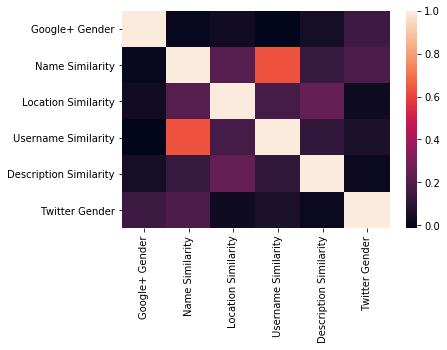

In [31]:
correlation_mat = data[features].corr()
column_names = ["Google+ Gender", "Name Similarity", "Location Similarity", "Username Similarity", "Description Similarity", "Twitter Gender"]
sea_fig = sns.heatmap(correlation_mat, 
            xticklabels=column_names,
            yticklabels=column_names).get_figure()
sea_fig.savefig("C:/Users/Dante/OneDrive - University of Glasgow/SD Work/MScProject/mproj/mproj/images/heatmap.png",
               bbox_inches='tight',
               pad_inches=0.5,
               dpi=1000)